(assign5asol)=
# Assign 5a: Water vapor retrieval solution

**New material is in Section: Assignment 5a: Answers**

## Near IR vs. IR datasets

Modis provides two separate measurements on the column integrated water vapor.
The high level overview is given in the [modis water vapor products](https://atmosphere-imager.gsfc.nasa.gov/products/water-vapor).  Basically the reason for two separate retrievals is that they have different strengths and weaknesses.

* Near Infrared Retrieval

  * Uses reflected photons in two separate water vapor absorption bands

  * Strengths

    * 1 km spatial resolution at nadir

    * retrieval doesn't depend on temperature difference between vapor and surface

    * more accurate than longwave

  * Weaknesses

    * Doesn't work at night

    * Doesn't work over dark surfaces (can work over ocean
      as long as the pixel is reflecting direct sunlight ("sunglint")

    * Needs separate MYD03 file for lats/lons

* Infrared Retrieval

  * Uses the water absorption bands near 11 microns

  * Strengths

    * Works day/night, over dark surfaces

    * 5 km lat/lons included in file

  * Weaknesses

    * 5 km pixels at nadir

    * Doesn't work when most of the vapor is in the boundary layer and has about the same temperature
      as the surface

* What this notebook does

1. Reads an MYD05 file named `MYD05*.hdf` located
   in `a301_lib.sat_data/hdf4_files` and grabs latitudes, longitudes and two arrays: `Water_Vapor_Near_Infrared` and
   `Water_Vapor_Infrared`

1. Scales the water vapar arrays by scale_factor and offset to produce the retrieved column water vapor
   in cm

1. Maps the two arrays onto the same 5km array for direct comparison

1. Maps the `near_ir` array onto a 1 km grid to show the full resolution.

1. Writes the three images with their area_def map information and metadata out to new folders in
   `./map_data/wv_maps` as npz files (for the images) and json files (for the metadata)

* Setup

1. Download the MYD05 granule that corresponds to your 5 minute date/time.  It should look something like:

         MYD05_L2.A2013222.2105.061.2018048043105.hdf

1. Copy it into the google_drive `a301_data` folder

In [1]:
import json
import pdb
import pprint
from pathlib import Path

import numpy as np
from IPython.display import display
from IPython.display import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from pyhdf.SD import SD
from pyhdf.SD import SDC

import a301_lib
from sat_lib.geometry import get_proj_params
from sat_lib.modismeta_read import parseMeta
## Image('figures/MYBRGB.A2016224.2100.006.2016237025650.jpg',width=600)
import h5py
from sat_lib.radiation import planck_invert
from sat_lib.modis_chans import chan_dict
import cartopy

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


In [2]:
%matplotlib inline

* Read in the 1km and 5km water vapor files

* Start with the lats/lons for 1km and 5km

In [3]:
m5_file= (a301_lib.sat_data / 'hdf4_files').glob("**/MYD05*2105*hdf")
m3_file = (a301_lib.sat_data / 'hdf4_files').glob("MYD03*2105*.hdf")
m5_file_str = str(list(m5_file)[0])
m3_file_str = str(list(m3_file)[0])
print(m5_file_str)
print(m3_file_str)

the_file = SD(m3_file_str, SDC.READ)
lats_1km = the_file.select("Latitude").get()
lons_1km = the_file.select("Longitude").get()
the_file.end()
print(lats_1km.shape)

the_file = SD(m5_file_str, SDC.READ)
lats_5km = the_file.select("Latitude").get()
lons_5km = the_file.select("Longitude").get()
the_file.end()
print(lats_5km.shape)

/home/phil/work/sat_data/hdf4_files/MYD05_L2.A2013222.2105.061.2018048043105.hdf
/home/phil/work/sat_data/hdf4_files/MYD03.A2013222.2105.006.2013223155808.hdf
(2040, 1354)
(408, 270)


* Get the IR vapor plus 5 of its attributes

Store the data in a numpy array, and the attributes in a dictionary,
using a [dictionary comprehension](https://jakevdp.github.io/WhirlwindTourOfPython/11-list-comprehensions.html)
at line 4

In [4]:
the_file = SD(m5_file_str, SDC.READ)
wv_ir = the_file.select("Water_Vapor_Infrared")
attributes = ["units", "scale_factor", "add_offset", "valid_range", "_FillValue"]
attr_dict = wv_ir.attributes()
wv_ir_attrs = {k: attr_dict[k] for k in attributes}
print(f"wv_ir attributes: {pprint.pformat(wv_ir_attrs)}")
wv_ir_data = wv_ir.get()
the_file.end()

wv_ir attributes: {'_FillValue': -9999,
 'add_offset': 0.0,
 'scale_factor': 0.0010000000474974513,
 'units': 'cm',
 'valid_range': [0, 20000]}


* Replace -9999 with np.nan

Note that this has to a happen before we scale the data by the scale_factor so the -9999 can be recognized

In [5]:
bad_data = wv_ir_data == wv_ir_attrs["_FillValue"]
#
# next line converts to floating point so we can use np.nan
#
wv_ir_data = wv_ir_data.astype(np.float32)
wv_ir_data[bad_data] = np.nan

* now scale the data and histogram it

In [6]:
wv_ir_scaled = wv_ir_data * attr_dict["scale_factor"] + attr_dict["add_offset"]

Note that we need to get rid of all nan values by taking ~ (not) np.isnan

```
plt.hist(wv_ir_scaled)
```
won't work

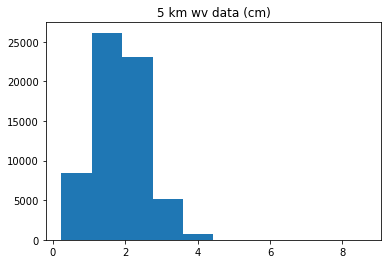

In [7]:
plt.hist(wv_ir_scaled[~np.isnan(wv_ir_scaled)])
ax = plt.gca()
ax.set_title("5 km wv data (cm)");

* Repeat for the 1 km near-ir data

Use a dictionary comprehension again to move the attributes in attrib_list into a dict at line 4

In [8]:
the_file = SD(m5_file_str, SDC.READ)
wv_nearir = the_file.select("Water_Vapor_Near_Infrared")
attrib_list = ["unit", "scale_factor", "add_offset", "valid_range", "_FillValue"]
attr_dict = wv_nearir.attributes()
wv_nearir_attrs = {k: attr_dict[k] for k in attrib_list}
print(f"wv_nearir attributes: {pprint.pformat(wv_nearir_attrs)}")
wv_nearir_data = wv_nearir.get()
the_file.end()

wv_nearir attributes: {'_FillValue': -9999,
 'add_offset': 0.0,
 'scale_factor': 0.0010000000474974513,
 'unit': 'cm',
 'valid_range': [0, 20000]}


In [9]:
bad_data = wv_nearir_data == wv_nearir_attrs["_FillValue"]
wv_nearir_data = wv_nearir_data.astype(np.float32)
wv_nearir_data[bad_data] = np.nan
wv_nearir_scaled = wv_nearir_data * attr_dict["scale_factor"] + attr_dict["add_offset"]

* Note that the  scaled wv values are similar between near_ir and ir retrievals

Text(0.5, 1.0, '1 km water vapor (cm)')

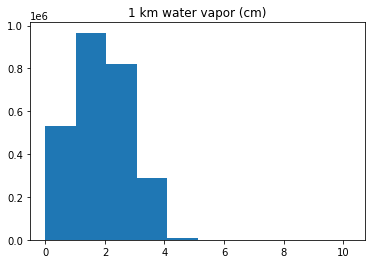

In [10]:
plt.hist(wv_nearir_scaled[~np.isnan(wv_nearir_scaled)])
ax = plt.gca()
ax.set_title("1 km water vapor (cm)")

### Map the data

* Resample the 5km IR retrieval onto a laea xy grid

Let swath_def.compute_optimal_bb_area choose the extent and dimensions for
the low resolution (lr) image.  The cell below let's pyresample create the
area_def object, which we will reuse for the 1 km watervapor retrieval to
get both onto the same grid.

The cell below produces:

* `image_wv_ir`  -- resampled 5 km infrared water vapor
* `area_def_lr`  -- area_def used for the resample

In [11]:
from pyresample import SwathDefinition, kd_tree, geometry

proj_params = get_proj_params(m5_file_str)
swath_def = SwathDefinition(lons_5km, lats_5km)
area_def_lr = swath_def.compute_optimal_bb_area(proj_dict=proj_params)
fill_value = -9999.0
image_wv_ir = kd_tree.resample_nearest(
    swath_def,
    wv_ir_scaled.ravel(),
    area_def_lr,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
image_wv_ir[image_wv_ir < -9000] = np.nan
print(f"\ndump area definition:\n{area_def_lr}\n")
print(
    (
        f"\nx and y pixel dimensions in meters:"
        f"\n{area_def_lr.pixel_size_x}\n{area_def_lr.pixel_size_y}\n"
    )
)

/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()



dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.4580671712606', 'lon_0': '-121.464976619873', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 499
Number of rows: 448
Area extent: (-1238434.2527, -1155685.6368, 1529176.4655, 1278445.1434)


x and y pixel dimensions in meters:
5546.3140647124765
5433.327634487678



/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


* Resample the 1km near-ir water vapor on the same grid

Reuse area_def_lr for the high resolution nearir image so we can compare directly with low resolution ir

The cell below produces:

* `image_wv_nearir_lr`  -- resampled using `area_def_lr`

In [12]:
swath_def = SwathDefinition(lons_1km, lats_1km)
fill_value = -9999.0
image_wv_nearir_lr = kd_tree.resample_nearest(
    swath_def,
    wv_nearir_scaled.ravel(),
    area_def_lr,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
#
# pyresampled pixels outside of image are set to -9999
#
image_wv_nearir_lr[image_wv_nearir_lr < -9000] = np.nan

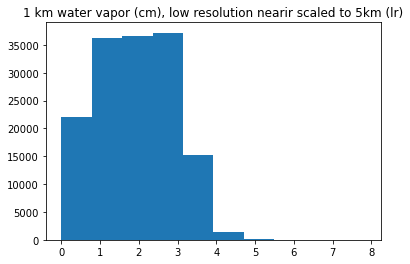

In [13]:
plt.hist(image_wv_nearir_lr[~np.isnan(image_wv_nearir_lr)])
ax = plt.gca()
ax.set_title("1 km water vapor (cm), low resolution nearir scaled to 5km (lr)");

* now use the 1 km MYD03 lons and lats to get a full resolution xy grid

resample the neair wv onto that grid to show full resolution image.  Call this
area_def area_def_hr

The cell below produces:

* `image_wv_nearir_hr`  -- 1 km near-ir watervapor
* `area_def_hr`  -- the `area_def` file used to do the 1 k resample

### Resample the 1 km near-ir water vapor onto a 1 km grid

In [14]:
proj_params = get_proj_params(m3_file_str)
swath_def = SwathDefinition(lons_1km, lats_1km)
area_def_hr = swath_def.compute_optimal_bb_area(proj_dict=proj_params)
# area_def_hr.name = "near ir wv retrieval modis 1 km resolution (hr=high resolution)"
# area_def_hr.area_id = "wv_nearir_hr"
# area_def_hr.job_id = area_def_hr.area_id
fill_value = -9999.0
image_wv_nearir_hr = kd_tree.resample_nearest(
    swath_def,
    wv_nearir_scaled.ravel(),
    area_def_hr,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
image_wv_nearir_hr[image_wv_nearir_hr < -9000] = np.nan

/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


### Save the mapped images
* Now save these three images plus their area_def's for future plotting

The function area_def_to_dict saves the pyresample area_def as a dict

At line 20 note that
```python
    a=getattr(area_def,key)
```
where key='my_attribute'  is the same as
```python
    a=area_def.my_attribute
```
but you don't have to hard-code in 'my_attribute'

In [15]:
import json


def area_def_to_dict(area_def):
    """
    given an area_def, save it as a dictionary`
    
    Parameters
    ----------
    
    area_def: pyresample area_def object
         
    Returns
    -------
    
    out_dict: dict containing
       area_def dictionary
         
    """
    keys = [
        "area_id",
        "proj_id",
        "name",
        "proj_dict",
        "x_size",
        "y_size",
        "area_extent",
    ]
    area_dict = {key: getattr(area_def, key) for key in keys}
    area_dict["proj_id"] = area_dict["area_id"]
    return area_dict

* Create a directory to hold the images and area_def dictionaries

In [16]:
map_dir = Path() / "map_data/wv_maps"
map_dir.mkdir(parents=True, exist_ok=True)

* Here's a function that writes the image plus metadata to npz and json files

We'll need to use area_def_to_dict when we create the metadata_dict

In [17]:
def dump_image(image_array, metadata_dict, foldername, image_array_name="image"):
    """
    write an image plus mmetadata to a folder
    
    Parameters
    ----------
    
    image_array: ndarray
        the 2-d image to be saved
    
    foldername:  Path object or string
        the path to the folder that holds the image files
        
    image_array_name:  str
        the root name for the npz and json files
        i.e. image.npz and image.json
        
    Returns: None
       side effect -- an npz and a json file are written
    """
    image_file = Path(foldername) / Path(image_array_name)
    out_dict = {image_array_name: image_array}
    np.savez(image_file, **out_dict)
    json_name = foldername / Path(image_array_name + ".json")
    with open(json_name, "w") as f:
        json.dump(metadata_dict, f, indent=4)
    print(f"\ndumping {image_file}\n and {json_name}\n")

### Write out images, putting useful metadeta in metadata_dict

We have three images:  

* `wv_ir` -- 5km ir retrieval
* `wv_nearir_hr`  -- 1 km nearir retrieval
* `wv_nearir_lr`  -- 1 km nearir retrieval resampled to 5 km grid

In [18]:
metadata_dict = dict(modismeta=parseMeta(m5_file_str))
map_dir.mkdir(parents=True, exist_ok=True)
map_dir = Path() / "map_data/wv_maps"

image_name = "wv_ir"
metadata_dict["area_def"] = area_def_to_dict(area_def_lr)
metadata_dict["image_name"] = image_name
metadata_dict["description"] = "modis ir water vapor (cm) sampled at 5 km resolution"
metadata_dict["history"] = "written by level2_cartopy_resample.ipynb"
dump_image(image_wv_ir, metadata_dict, map_dir, image_name)

image_name = "wv_nearir_hr"
metadata_dict["area_def"] = area_def_to_dict(area_def_hr)
metadata_dict["image_name"] = image_name
metadata_dict[
    "description"
] = "modis near ir water vapor (cm) sampled at 1 km resolution"
metadata_dict["history"] = "written by level2_cartopy_resample.ipynb"
dump_image(image_wv_nearir_hr, metadata_dict, map_dir, image_name)


image_name = "wv_nearir_lr"
metadata_dict["area_def"] = area_def_to_dict(area_def_lr)
metadata_dict["image_name"] = image_name
metadata_dict[
    "description"
] = "modis near ir water vapor (cm) sampled at 5 km resolution"
metadata_dict["history"] = "written by level2_cartopy_resample.ipynb"


dump_image(image_wv_nearir_lr, metadata_dict, map_dir, image_name)


dumping map_data/wv_maps/wv_ir
 and map_data/wv_maps/wv_ir.json


dumping map_data/wv_maps/wv_nearir_hr
 and map_data/wv_maps/wv_nearir_hr.json


dumping map_data/wv_maps/wv_nearir_lr
 and map_data/wv_maps/wv_nearir_lr.json



/home/phil/mini38/envs/work/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [19]:
area_def_lr

Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.4580671712606', 'lon_0': '-121.464976619873', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 499
Number of rows: 448
Area extent: (-1238434.2527, -1155685.6368, 1529176.4655, 1278445.1434)

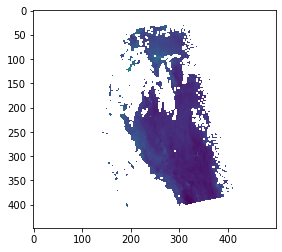

In [20]:
fig, ax = plt.subplots(1,1)
ax.imshow(image_wv_ir)

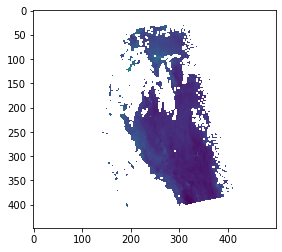

In [21]:
fig, ax = plt.subplots(1,1)
ax.imshow(image_wv_ir)

In [22]:
area_def_hr

Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.5993004712551', 'lon_0': '-121.404653237522', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2534
Number of rows: 2244
Area extent: (-1269189.1278, -1177871.0124, 1531795.604, 1265796.0146)

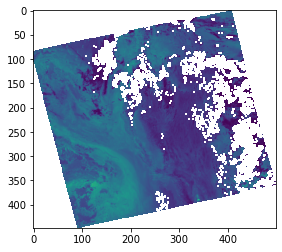

In [23]:
fig, ax = plt.subplots(1,1)
ax.imshow(image_wv_nearir_lr)

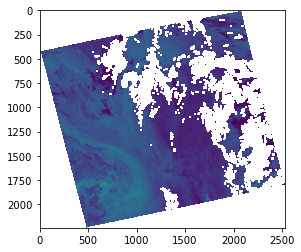

In [24]:
fig, ax = plt.subplots(1,1)
ax.imshow(image_wv_nearir_hr)

## Assignment 5a -- answers

Add cells that do the following:

1) Read your MYD05 and MYD03 files and show your 1km, and 5km IR and 5 km nearir regridded MYD05 water vapor images

2) Regrid your Channel 32/31 brightness temperature map on the MYD05 `area_def_hr` grid.

3) Draw a scatterplot showing the correlation between your 1km and 5km water vapor retrievals

4) Draw a scatterplot showing the correlation between your 1km MYD05 and brightness temperature difference cells

* **Question 1 see images above**

* **Question 2:  reproduce the plot from [Assignment 3](https://a301_web.eoas.ubc.ca/week5/assignment3.html#assign3) below**

a) grab the lats and lons

In [25]:
geom_filelist = list(a301_lib.sat_data.glob("h5_dir/geom*2105*h5"))
geom_file_name = geom_filelist[0]
print(geom_file_name)
with h5py.File(geom_file_name,'r') as f:
    print(list(f.keys()))
    geom_group = f['geometry']
    print(list(geom_group.keys()))
    lats = geom_group['latitude'][...]
    print(lats.shape)
    lons = geom_group['longitude'][...]
    print(lons.shape)
    print(f.attrs.keys())

/home/phil/work/sat_data/h5_dir/geom_MYD03.A2013222.2105.006.2013223155808.h5
['geometry']
['latitude', 'longitude']
(2040, 1354)
(2040, 1354)
<KeysViewHDF5 ['CoreMetadata.0', 'history']>


b) grab the radiances

In [26]:
rad_file_name = list(a301_lib.sat_data.glob("h5_dir/oct9*2105*h5"))[0]
with h5py.File(rad_file_name,'r') as f:
    print(list(f.keys()))
    channel_group = f['channels']
    print(list(channel_group.keys()))
    ch31 = channel_group['chan31'][...]
    ch32 = channel_group['chan32'][...]
    print(ch31.shape)

['channels']
['chan30', 'chan31', 'chan32']
(2040, 1354)


c) figure out the middle of the each channel and get the brightness temperature

Tdiff = clean channel - "dirty" channel, where water vapor makes a the channel dirty

https://cimss.ssec.wisc.edu/satellite-blog/archives/23702

In [27]:
chan31_mid = (chan_dict['31']['wavelength_um'][0] + chan_dict['31']['wavelength_um'][1])/2.
chan32_mid = (chan_dict['32']['wavelength_um'][0] + chan_dict['32']['wavelength_um'][1])/2.
print(f"mid-channel wavelengths: {chan31_mid}, {chan32_mid}")
T31 = planck_invert(chan31_mid*1.e-6, ch31*1.e6)
T32 = planck_invert(chan32_mid*1.e-6, ch32*1.e6)

Tdiff = T31 -T32

mid-channel wavelengths: 11.03, 12.02


d) Grid Tdiff onto area_def_hr, should get same picture as assignment 3

In [28]:
fill_value = -9999.0
area_name = "modis swath 5min granule"
image_Tdiff = kd_tree.resample_nearest(
    swath_def,
    Tdiff.ravel(),
    area_def_hr,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
print(f"\ndump area definition:\n{area_def_hr}\n")
print(
    (
        f"\nx and y pixel dimensions in meters:"
        f"\n{area_def_hr.pixel_size_x}\n{area_def_hr.pixel_size_y}\n"
    )
)


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.5993004712551', 'lon_0': '-121.404653237522', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 2534
Number of rows: 2244
Area extent: (-1269189.1278, -1177871.0124, 1531795.604, 1265796.0146)


x and y pixel dimensions in meters:
1105.3609833643736
1088.9781760558744



e) replaced all the missing values with a 32 bit nan

(we do this by making a 1x1 array using np.array)

In [29]:
nan_value = np.array([np.nan], dtype=np.float32)[0]
image_Tdiff[image_Tdiff < -9000] = nan_value

f) Plot on a map

Text(0.5, 1.0, 'Ch 31 - Ch 32 BTD (K) at 1 km resolution')

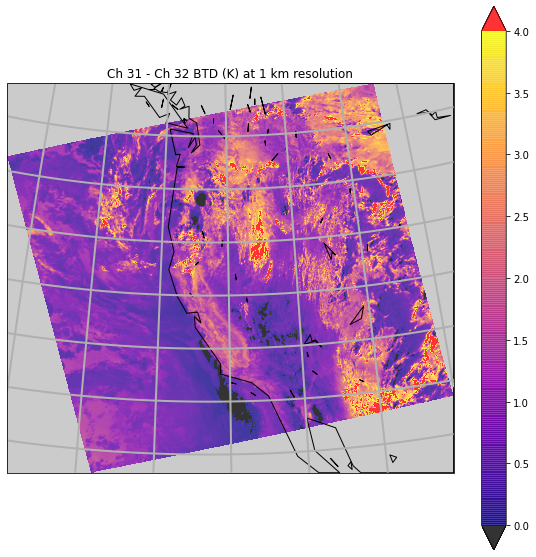

In [30]:
import copy
pal = copy.copy(plt.get_cmap("plasma"))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("r")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
vmin = 0.
vmax = 4.
from matplotlib.colors import Normalize

the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)

cartopy_crs = area_def_hr.to_cartopy_crs()
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={"projection": cartopy_crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
ax.set_extent(cartopy_crs.bounds, cartopy_crs)
cs = ax.imshow(
    image_Tdiff,
    transform=cartopy_crs,
    extent=cartopy_crs.bounds,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
fig.colorbar(cs, extend="both");
ax.set_title("Ch 31 - Ch 32 BTD (K) at 1 km resolution")

* **Question 3) Scatterplot of near-ir vs. ir water vapor at 5 km resolution**

Here's the map of the high resolution near-ir water vapor at low resolution

cartopy_crs=_PROJ4Projection(+datum=WGS84 +ellps=WGS84 +lat_0=39.4580671712606 +lon_0=-121.464976619873 +no_defs=True +proj=laea +type=crs +units=m +x_0=0.0 +y_0=0.0 +no_defs)


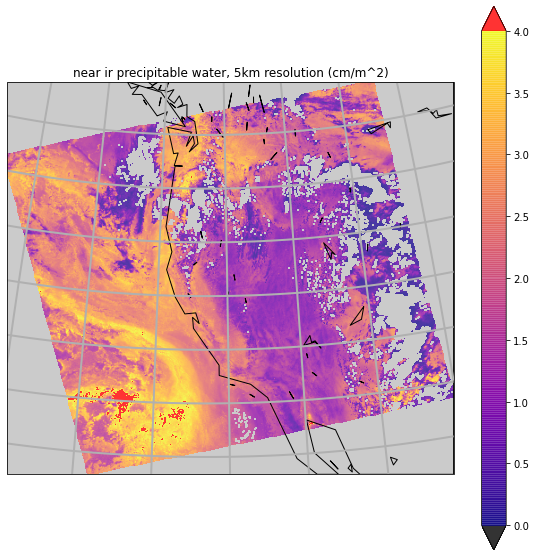

In [31]:
import copy
vmin = 0.
vmax = 4.
from matplotlib.colors import Normalize

the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)
cartopy_crs = area_def_lr.to_cartopy_crs()
print(f"{cartopy_crs=}")
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={"projection": cartopy_crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
ax.set_extent(cartopy_crs.bounds, cartopy_crs)
cs = ax.imshow(
    image_wv_nearir_lr,
    transform=cartopy_crs,
    extent=cartopy_crs.bounds,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
fig.colorbar(cs, extend="both")
ax.set_title('near ir precipitable water, 5km resolution (cm/m^2)');

And here's the IR water vapor on the same grid -- note that as we saw in the images above, it fails consistently over
the ocean -- because it can't handle situations were the water vapor near the surface
is dominating the water vapor emissions:  https://atmosphere-imager.gsfc.nasa.gov/products/water-vapor
The channel difference technique depends on the water vapor being colder than the surface, and that's
not true over the ocean.

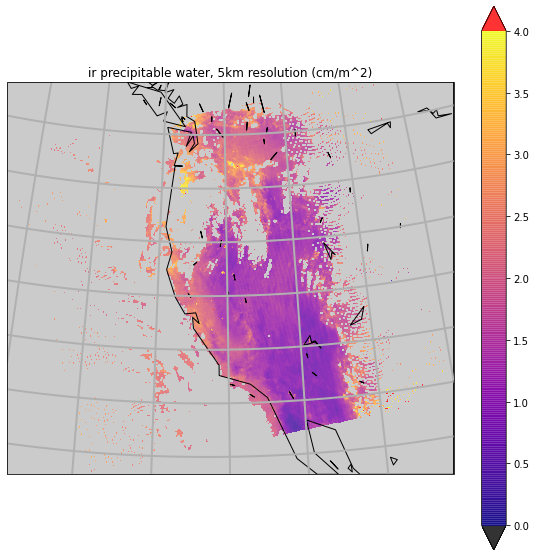

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), subplot_kw={"projection": cartopy_crs})
ax.gridlines(linewidth=2)
ax.add_feature(cartopy.feature.GSHHSFeature(scale="coarse", levels=[1, 2, 3]))
ax.set_extent(cartopy_crs.bounds, cartopy_crs)
cs = ax.imshow(
    image_wv_ir,
    transform=cartopy_crs,
    extent=cartopy_crs.bounds,
    origin="upper",
    alpha=0.8,
    cmap=pal,
    norm=the_norm,
)
fig.colorbar(cs, extend="both")
ax.set_title('ir precipitable water, 5km resolution (cm/m^2)');

* Plot the scatter plot

At least some of the values show approximate 1 to 1 correlation

Text(0.5, 1.0, 'neair vs ir water vapor at 5 km resolution')

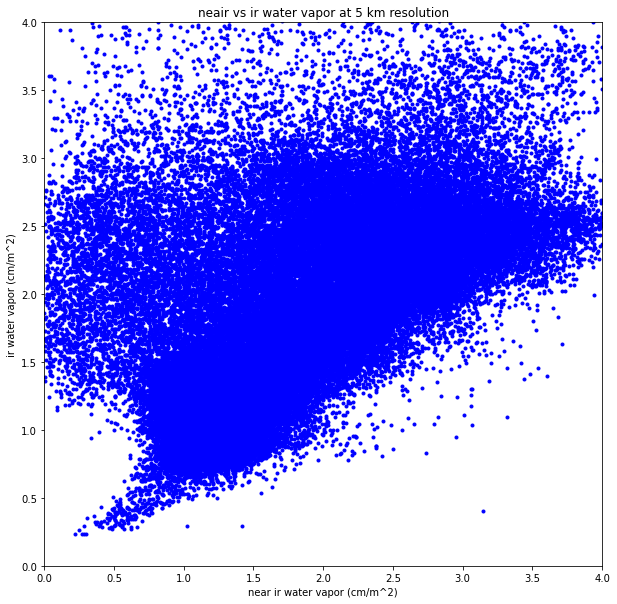

In [33]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(image_wv_nearir_lr,image_wv_ir,'b.');
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_xlabel('near ir water vapor (cm/m^2)')
ax.set_ylabel('ir water vapor (cm/m^2)')
ax.set_title('neair vs ir water vapor at 5 km resolution')

* Here is the joint histogram version of the scatterplot

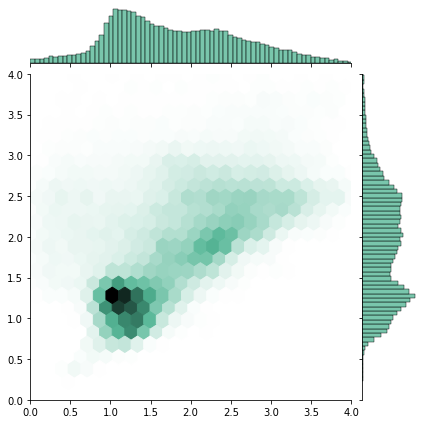

In [34]:
import seaborn as sns
sns.jointplot(
    x=image_wv_nearir_lr.flat,
    y=image_wv_ir.flat,
    xlim=(0, 4),
    ylim=(0.0, 4),
    kind="hex",
    color="#4CB391",
);

* **Question 4) Scatterplot for near-ir water vapor vs. channel 31-32 BTD**

Not so great -- since we haven't excluded the ocean pixels, we get lots
of pixels with no correlation.  In order to see any kind of pattern, I thin
the data by taking a random sample of 50,000 pixels

In [35]:
import numpy as np
near_ir_flat = image_wv_nearir_hr.flat
Tdiff_flat = image_Tdiff.flat
subset = np.random.randint(0, high=len(near_ir_flat), size=50000, dtype='l')

Text(0.5, 1.0, 'near ir vs. BTD at 1 km resolution')

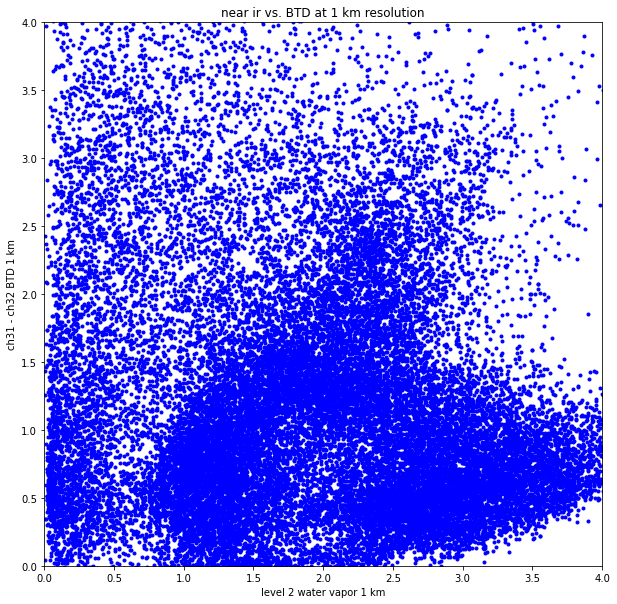

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(near_ir_flat[subset],Tdiff_flat[subset],'b.');
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_xlabel('level 2 water vapor 1 km')
ax.set_ylabel('ch31 - ch32 BTD 1 km')
ax.set_title('near ir vs. BTD at 1 km resolution')

*  Here is the joint distribution plot

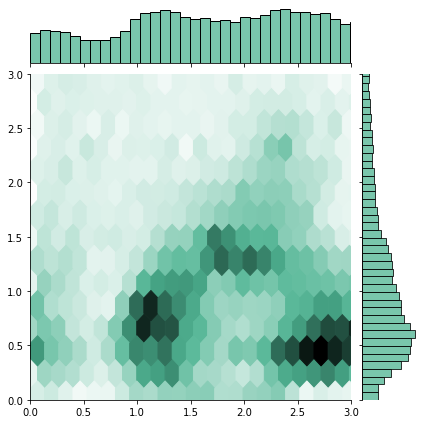

In [37]:
import seaborn as sns
sns.jointplot(
    x=near_ir_flat[subset],
    y=Tdiff_flat[subset],
    xlim=(0, 3),
    ylim=(0.0, 3),
    kind="hex",
    color="#4CB391",
);

## Appendix -- try resampling the BTD to 5 km

In [38]:
fill_value = -9999.0
area_name = "modis swath 5min granule"
image_Tdiff_lr = kd_tree.resample_nearest(
    swath_def,
    Tdiff.ravel(),
    area_def_lr,
    radius_of_influence=5000,
    nprocs=2,
    fill_value=fill_value,
)
print(f"\ndump area definition:\n{area_def_lr}\n")
print(
    (
        f"\nx and y pixel dimensions in meters:"
        f"\n{area_def_lr.pixel_size_x}\n{area_def_lr.pixel_size_y}\n"
    )
)


dump area definition:
Area ID: laea_otf
Description: On-the-fly laea area
Projection: {'datum': 'WGS84', 'lat_0': '39.4580671712606', 'lon_0': '-121.464976619873', 'no_defs': 'None', 'proj': 'laea', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 499
Number of rows: 448
Area extent: (-1238434.2527, -1155685.6368, 1529176.4655, 1278445.1434)


x and y pixel dimensions in meters:
5546.3140647124765
5433.327634487678



We'll also remove all pixels that are set to NaN in the IR water vapor image.  Once the
ocean pixels are taken out, the comparison looks a little better

Text(0.5, 1.0, 'nearir vs BTD at 5 km resolution, land only')

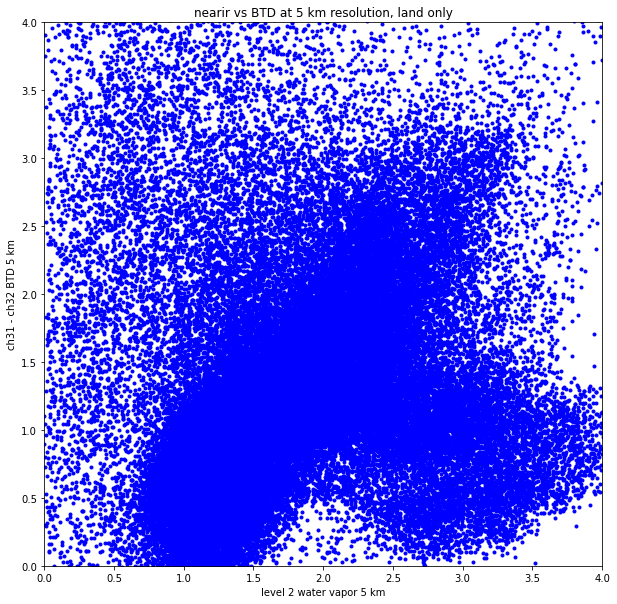

In [39]:
good_pixels = ~np.isnan(image_wv_ir)
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(image_wv_nearir_lr[good_pixels],image_Tdiff_lr[good_pixels],'b.');
ax.set_xlim(0,4)
ax.set_ylim(0,4)
ax.set_xlabel('level 2 water vapor 5 km')
ax.set_ylabel('ch31 - ch32 BTD 5 km')
ax.set_title('nearir vs BTD at 5 km resolution, land only')

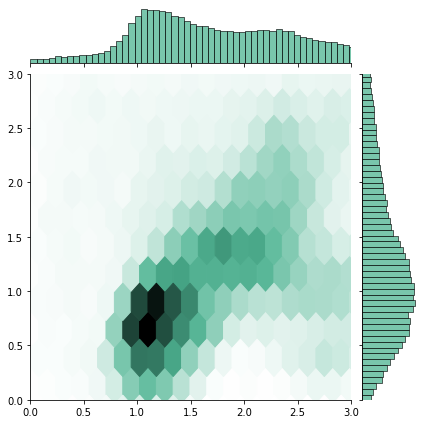

In [40]:
import seaborn as sns
sns.jointplot(
    x=image_wv_nearir_lr[good_pixels],
    y=image_Tdiff_lr[good_pixels],
    xlim=(0, 3),
    ylim=(0.0, 3),
    kind="hex",
    color="#4CB391",
);